# Unrolling neural network training

In [8]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)

import warnings
warnings.filterwarnings("ignore")


## Toy case models and datasets

In [9]:
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y_train to match model output shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape y_test to match model output shape

In [20]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

In [28]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Shape: {param}, Dtype: {param.dtype}")

Parameter name: 0.weight, Shape: Parameter containing:
tensor([[-1.0346e+00,  6.2389e-01, -1.0797e+00,  7.8317e-01, -8.6354e-01,
         -1.9224e-01, -1.6218e+00,  8.6188e-01, -2.6049e-01, -5.5163e-01,
          5.6721e-01,  1.1714e+00,  4.5271e-01],
        [-1.4258e+00, -3.6481e-02, -5.6696e-01, -9.4656e-01, -2.7237e-01,
          1.6556e+00, -5.2755e-01,  1.3275e-01, -9.2070e-01, -1.1447e+00,
         -2.0586e-01,  4.2844e-01, -2.1657e-03],
        [-1.1305e+00, -1.3530e+00,  9.1565e-01,  5.0802e-01, -5.9766e-01,
         -1.2530e+00, -4.7714e-01, -1.9135e+00,  2.7283e-02, -5.5570e-02,
         -1.1352e+00,  6.3929e-01, -9.3514e-01],
        [-1.3148e+00, -2.7417e-01, -2.8234e-01, -4.4935e-01, -5.0775e-01,
          1.2385e+00, -7.4419e-01,  1.5403e-01, -7.5280e-01, -8.3993e-01,
         -8.7209e-01,  8.1866e-01, -4.8006e-01],
        [-9.6336e-01, -5.8634e-01,  4.5377e-01, -2.2979e-01, -1.0874e+00,
         -6.9124e-01, -5.7154e-02,  5.4381e-01, -1.1181e+00, -2.3354e-01,
         

### Simple training loop 

In [22]:
train_losses = []

for epoch in range(100):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 116.2047
Epoch [20/100], Loss: 40.2300
Epoch [30/100], Loss: 21.5361
Epoch [40/100], Loss: 16.2013
Epoch [50/100], Loss: 13.5249
Epoch [60/100], Loss: 11.8810
Epoch [70/100], Loss: 10.5504
Epoch [80/100], Loss: 9.7938
Epoch [90/100], Loss: 9.2201
Epoch [100/100], Loss: 8.6951
Test Loss: 11.3871


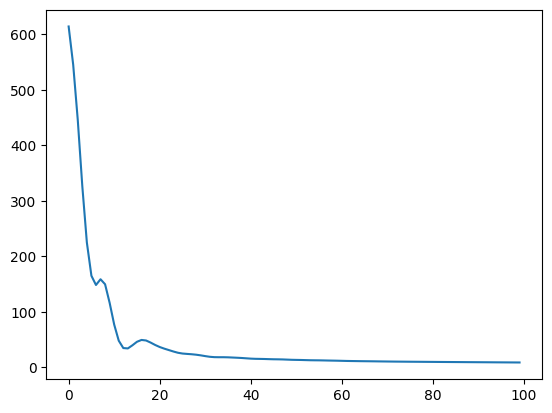

In [24]:
plt.plot(train_losses)

### SCANTRA - DeepUnrolling SCA for Neural networks TRAining

Let's try to define a surrogate loss using a general purpose second order approximations and the gradient of the feedforward network. 

In [29]:
class SCANTRALayer(nn.Module):
    def __init__(self, model, lambda_ = 0.1, tau = 1):
        super().__init__()

        self.model = model

        # Initialization of the learnable parameters
        self.lambda_ = nn.Parameter(torch.ones(1)*lambda_, requires_grad = True)
        self.tau = nn.Parameter(torch.ones(1)*tau, requires_grad = True)
        self.B = nn.Parameter(torch.randn(30), requires_grad = True)

    def forward(self):
        for _, p in self.model.named_parameters():

            # Local optimization step

            K = p.grad
            H = torch.outer(self.B,self.B) + self.tau*torch.eye(self.B.shape[0])
            w_hat = torch.linalg.inv((2*self.lambda_ + self.tau)*torch.eye(30) + H) @ (H @ p - K)

            p = p + self.gamma*(w_hat - p)

In [ ]:
class SCANTRANet(nn.Module):
    def __init__(self, model, T = 10, lambda_ = 0.1, tau = 25, gamma = 0.99):
        super(SCANTRANet, self).__init__()

        # Measurements matrix
        self.model = model
        
        # Number of iterations <-> number of layers
        self.T = T

        # Initialization of the learnable parameters
        self.lambda_0 = torch.ones(T)*lambda_
        self.tau_0 = torch.ones(T)*tau
        self.gamma_0 = torch.ones(T)*gamma

        for i in range(self.T):
            self.gamma_0[i] *= 0.99**i
            
        # Defining the layers
        self.SCANTRA_layers = nn.ModuleList([SCANTRALayer(self.model, 
                                                        self.lambda_0[i], 
                                                        self.tau_0[i], 
                                                        self.gamma_0[i]
                                                        ) for i in range(self.T)])
        
    def forward(self, y):
        for i in range(self.T-1):
            self.SCANTRA_layers[i].forward()

        return self.model